In [1]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN


import matplotlib.pyplot as plt
import tensorflow as tf
# from cuml.cluster import HDBSCAN
# from cuml.manifold import UMAP
# from cuml.preprocessing import normalize

from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer 
import string
import re
import nltk
from bs4 import BeautifulSoup   
import contractions,unicodedata


nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.


import spacy
from sklearn.cluster import KMeans
import plotly.express as px

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\p_uli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\p_uli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\p_uli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
data= pd.read_csv(r'C:\Users\p_uli\Desktop\Columbia University\Cursos\Fall 22\Capstone\Data\data_clean_processed_sample.csv')
data.head()

,email_id,subject,email,bow,embeddings
0,saibi-e\inbox\612#1,WSCC (Mahave 02) (San Juan 03),"Dear Power Outage Database Customer,\n\nAttach...",dear power outage database customer attached f...,"dear power outage database customer, attached ..."
1,kitchen-l\_americas\netco_restart\28#2,RE:,Ryan is waffling. I talked to him this weeken...,ryan waffling talked weekend said wife want mo...,ryan waffling. talked weekend said wife want m...
2,motley-m\sent_items\1#1,SSARR Update Available Now,"<center><LI><a Href=""http://www.nwrfc.noaa.gov...",columbia river basin lower snake updated mar,columbia river basin lower snake.....updated: mar
3,kaminski-v\all_documents\577#1,Credit Risk Model Comments - at this point.,"Hi everyone,\n\nI have run the model and, alon...",everyone run model along contract brief questi...,"everyone, run model and, along contract brief ..."
4,quigley-d\sent_items\480#1,Confirmation: Risk Management Simulation Mee...,"Hi Dutch, This message is to confirm ou...",dutch message confirm meeting thursday novembe...,"dutch, message confirm meeting on, thursday, n..."


In [21]:
if type(data['embeddings']) is list:
    text = data['embeddings']
else:
    text = data['embeddings'].tolist()

text=[str(x) for x in text]

### Embedding

In [22]:
# %%time
# with tf.device('/GPU:0'):
#     # embedding
#     sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
#     #sentence_model = SentenceTransformer('all-MiniLM-L12-v2')
#     embeddings = sentence_model.encode(text, show_progress_bar=True)

# all_embeddings = np.array(embeddings)
# np.save('embeddings_L6-v2.npy', all_embeddings)
embeddings= np.load('embeddings_L6-v2.npy')
#embeddings= np.load('embeddings.npy')

### Model

In [12]:
def create_model(topwords,n_gram,min_top ):
    nn=10
    min_cluster=10
    from nltk.corpus import stopwords
    stop_w = stopwords.words('english')
#     stop_w = stop_w+['imagemasker','urlmasker','tofrom','namemasker','im','smith','john','pm']
    stop_w = stop_w+['tofrom','namemasker','im','smith','john','pm']
    
    # ngrams
    vectorizer_model = CountVectorizer(ngram_range=n_gram, stop_words=stop_w)
    
    # UMAP: dimensionality reduction
    umap_model = UMAP(n_neighbors=nn, min_dist=0.0, metric='cosine', random_state=42)
    
    # HDBSCAN: clustering
    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster, metric='euclidean', 
                            cluster_selection_method='eom', prediction_data=True, min_samples=5)
    
#     cluster_model = KMeans(n_clusters=min_top)
    
    # BERTopic
    model = BERTopic(
        top_n_words=topwords,
#         min_topic_size=min_top,
        nr_topics=min_top,
        vectorizer_model=vectorizer_model,
        language='english', calculate_probabilities=True,
        verbose=True,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
    )
    
    return model

### Trying different number of topics

In [126]:
# number of topics to try
n_topics=[1] + [5*2**x for x in range(7)] + ['auto',400,450,500,550,600]
n_topics

[1, 5, 10, 20, 40, 80, 160, 320, 'auto', 400, 450, 500, 550, 600]

In [125]:
# will store probas, topics and frequencies
probas={}
topics_dic={}
frequencies={}


In [121]:
# %%time
# # run all the topics
# for i in n_topics:
#     model=create_model(10,(1,2),i)
#     with tf.device('/GPU:0'):
#         topics, probs = model.fit_transform(text,embeddings)

#     file_name='all-MiniLM-L6-v2_10_(1,2)_' + str(i)
#     # save the model
#     model.save(file_name)
    
#     # save results
#     probas[i]=model.probabilities_
#     topics_dic[i]=model.topics_
#     frequencies[i]=model.get_topic_info()

In [127]:
# load all results
for i in n_topics:
    file_name='all-MiniLM-L6-v2_10_(1,2)_' + str(i)
    model= BERTopic.load(file_name)
    
    probas[i]=model.probabilities_
    topics_dic[i]=model.topics_
    frequencies[i]=model.get_topic_info()
    


In [129]:
import pickle
with open('probas.pkl', 'wb') as f:
    pickle.dump(probas, f)
with open('topics.pkl', 'wb') as f:
    pickle.dump(topics_dic, f)
with open('frequencies.pkl', 'wb') as f:
    pickle.dump(frequencies, f)
    
# with open('saved_dictionary.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)

### plot of number of outliers

In [130]:
n_outliers=[]
for i in n_topics:
    n_outliers.append(frequencies[i]['Count'][0])

In [131]:
# number of topcis in 'auto'
n_topcis_auto=len(frequencies['auto']['Count'])-1

In [132]:
n_outliers

[19450,
 17713,
 16727,
 15152,
 13544,
 11742,
 9296,
 7239,
 6601,
 6742,
 6601,
 6601,
 6601,
 6601]

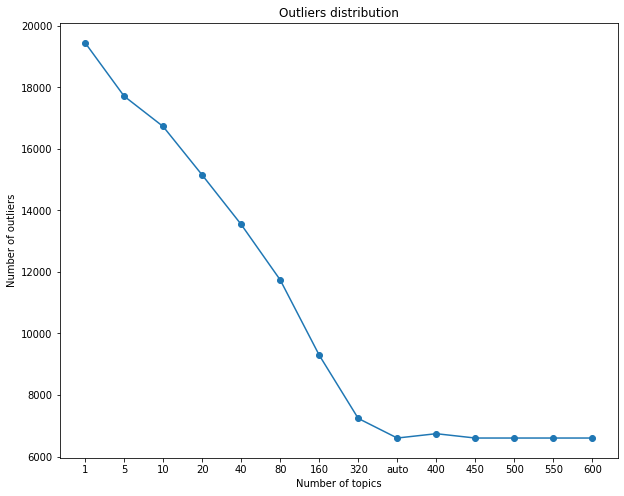

In [183]:
plt.figure(figsize=(10,8))
#adding text inside the plot
# plt.text(5, 7000, '$auto = 351$', fontsize = 22)
plt.ylabel('Number of outliers');
plt.xlabel('Number of topics');
plt.title('Outliers distribution');
#plt.plot(n_topics[:-1]+[n_topcis_auto],n_outliers,'o-');
plt.plot(n_topics,n_outliers,'o-');


In [184]:
print("Number of topics using parameter 'auto': {}".format(1+max(topics_dic['auto'])))

Number of topics using parameter 'auto': 352


In [185]:
print("Number of topics without specifying the parameter: 422")

Number of topics without specifying the parameter: 422


In [186]:
pd.DataFrame(zip(n_topics,n_outliers),columns=['Number of topics','Number of outliers'])

,Number of topics,Number of outliers
0,1,19450
1,5,17713
2,10,16727
3,20,15152
4,40,13544
5,80,11742
6,160,9296
7,320,7239
8,auto,6601
9,400,6742


In [187]:
pd.DataFrame.from_dict({'Method':['Auto','Default'],'Number of topics':[351,423]})

,Method,Number of topics
0,Auto,351
1,Default,423
